In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Import necessary libraries
from src.models import RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [ ]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_1.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_1.mat')
data_out = scipy.io.loadmat(filepath)


# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
    
nExp = yExp.size


In [4]:
# Create time vector
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 3)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 2

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        )    
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))            # to smooth the input signal of Qhot (noisy)

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [5]:
# Set number of epochs
epochs = 300

# Set dimensions for RNN layers
idd = 3
odd = yExp[0, 0].shape[1]

# Initialize variable to track the smallest loss
best_loss = float('inf')
best_hdd_ldd = None  # To track which hdd, ldd combination gives the best loss

for hdd in [1,10, 50,100]:  
    for ldd in [1,2]:
        print(f"Training RNN with hdd={hdd} and ldd={ldd}")
        
        # Initialize RNN model
        RNN = RNNModel(idd, hdd, ldd, odd)
        
        # Define loss function
        MSE = nn.MSELoss()

        # Define optimization method
        learning_rate = 5.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
        optimizer.zero_grad()

        # Initialize array to store loss values
        LOSS = np.zeros(epochs)

        # Train the RNN model
        for epoch in range(epochs):
            # Adjust learning rate at certain epochs
            if epoch == epochs - epochs // 2:
                learning_rate = 1.0e-3
                optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
            if epoch == epochs - epochs // 6:
                learning_rate = 1.0e-4
                optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
            
            optimizer.zero_grad()

            # Get RNN output for training data
            yRNN = RNN(u)
            yRNN = torch.squeeze(yRNN)

            # Calculate loss and backpropagate
            loss = MSE(yRNN, y)
            loss.backward()
            optimizer.step()

            # Print loss for the current epoch
            #print(f"Epoch: {epoch + 1} \t||\t Loss: {loss.item()}")
            LOSS[epoch] = loss.item()
        print(f"loss for model with hdd={hdd}, ldd={ldd} : loss={LOSS[-1]}")
        # Check if this model has the smallest loss
        final_loss = LOSS[-1]  # Loss at the last epoch
        if final_loss < best_loss:
            best_loss = final_loss
            best_hdd_ldd = (hdd, ldd)
            
            # Save the model parameters with the lowest loss
            torch.save(RNN.state_dict(), 'best_RNN_direct.pth')
            print(f"Best model so far saved with hdd={hdd}, ldd={ldd} and loss={best_loss}")
            
print(f"Training completed. Best model was with hdd={best_hdd_ldd[0]}, ldd={best_hdd_ldd[1]} and loss={best_loss}")

Training RNN with hdd=1 and ldd=1
loss for model with hdd=1, ldd=1 : loss=0.004789639730006456
Best model so far saved with hdd=1, ldd=1 and loss=0.004789639730006456
Training RNN with hdd=1 and ldd=2
loss for model with hdd=1, ldd=2 : loss=0.009247798472642899
Training RNN with hdd=10 and ldd=1
loss for model with hdd=10, ldd=1 : loss=0.002632119692862034
Best model so far saved with hdd=10, ldd=1 and loss=0.002632119692862034
Training RNN with hdd=10 and ldd=2


KeyboardInterrupt: 

In [20]:
 # Load the model parameters before starting a new training session
# Initialize RNN model
# Set dimensions for RNN layers
idd = 3
odd = yExp[0, 0].shape[1]
hdd = 100
ldd = 1
RNN = RNNModel(idd, hdd, ldd, odd)
epochs = 300

# Define loss function
MSE = nn.MSELoss()
#RNN.load_state_dict(torch.load('best_RNN_direct.pth'))
# Define optimization method
learning_rate = 5.0e-3
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Initialize array to store loss values
LOSS = np.zeros(epochs)

for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    

    # Calculate loss and backpropagate
    loss = MSE(yRNN[:,:,:], y[:,:,:])
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

Epoch: 1 	||	 Loss: 0.515171468257904
Epoch: 2 	||	 Loss: 0.22069956362247467
Epoch: 3 	||	 Loss: 0.008703223429620266
Epoch: 4 	||	 Loss: 0.42526641488075256
Epoch: 5 	||	 Loss: 0.0181130263954401
Epoch: 6 	||	 Loss: 0.0534692145884037
Epoch: 7 	||	 Loss: 0.10374737530946732
Epoch: 8 	||	 Loss: 0.11311457306146622
Epoch: 9 	||	 Loss: 0.09564778953790665
Epoch: 10 	||	 Loss: 0.062177035957574844
Epoch: 11 	||	 Loss: 0.02529783733189106
Epoch: 12 	||	 Loss: 0.010813378728926182
Epoch: 13 	||	 Loss: 0.039982154965400696
Epoch: 14 	||	 Loss: 0.05026118457317352
Epoch: 15 	||	 Loss: 0.024765385314822197
Epoch: 16 	||	 Loss: 0.009241441264748573
Epoch: 17 	||	 Loss: 0.011983988806605339
Epoch: 18 	||	 Loss: 0.020126324146986008
Epoch: 19 	||	 Loss: 0.025064490735530853
Epoch: 20 	||	 Loss: 0.02430601976811886
Epoch: 21 	||	 Loss: 0.018891487270593643
Epoch: 22 	||	 Loss: 0.01186578068882227
Epoch: 23 	||	 Loss: 0.007143011316657066
Epoch: 24 	||	 Loss: 0.007531751878559589
Epoch: 25 	||	 Lo

In [ ]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 3)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
            (torch.from_numpy(dExp_val[0, j][:, 3:]),    # Take columns 3 to 5
            torch.from_numpy(buildtot_val[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)), 
            dim=-1
        ) 
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

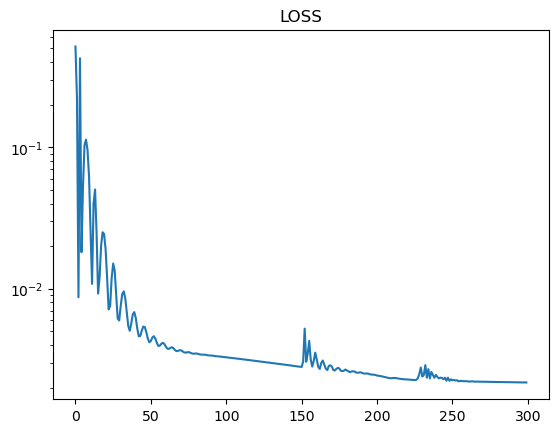

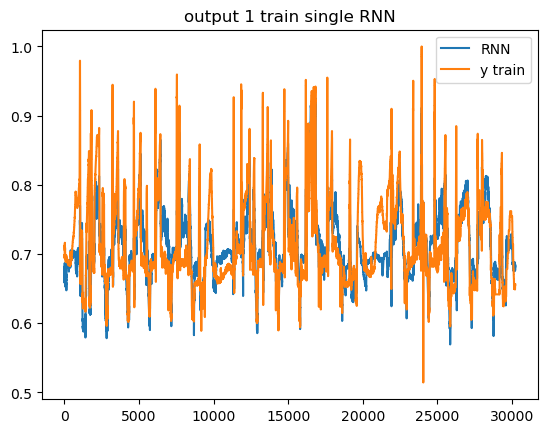

torch.Size([1, 30240, 2])


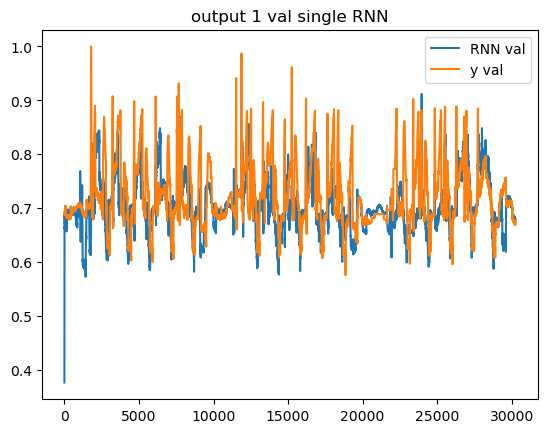

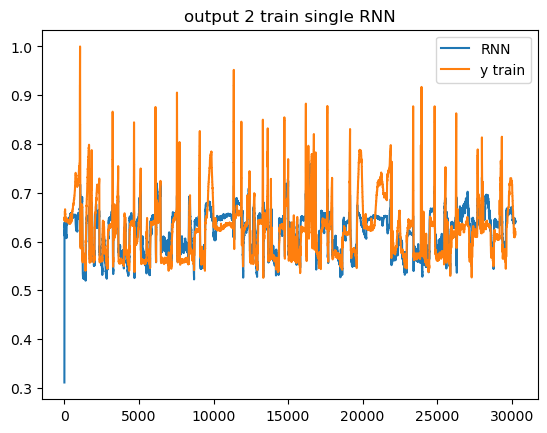

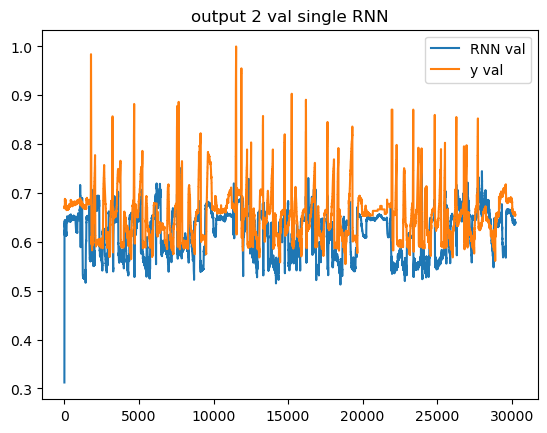

Loss Validation single RNN: 0.004680362995713949


In [ ]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.yscale('log')
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yRNN[0, 10:, 0].detach().numpy(), label='RNN')
plt.plot(y[0, 10:, 0].detach().numpy(), label='y train')
plt.title("output 1 train single RNN")
plt.legend()
plt.show()
print(yRNN_val.shape)
# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0,:, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yRNN[0, :, 1].detach().numpy(), label='RNN')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single RNN")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")

In [ ]:
#0.004274(1,1)
# 0.002039 (10,1)
# 0.0017160(50,1)
# 0.001407 (100,1)

# 0.0083582(1,2)
# 0.0018947 (10,2)
# 0.00151887(50,2)
# 0.0017852(100,2)

# 150,1 : 0.0043703

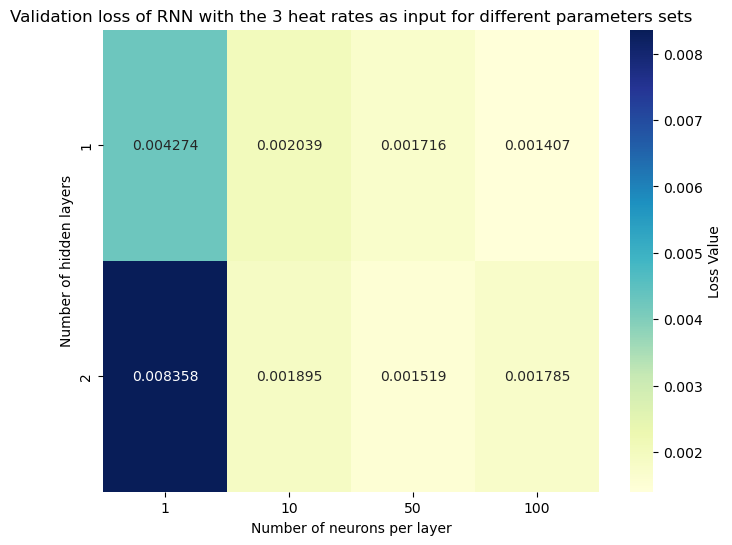

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for neurons, layers, and loss values
data = {
    "neurons": [1, 10, 50, 100, 1, 10, 50, 100],
    "layers": [1, 1, 1, 1, 2, 2, 2, 2],
    "loss": [0.004274, 0.002039, 0.001716, 0.001407, 0.0083582, 0.0018947, 0.0015188, 0.0017852]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot the data for heatmap
pivot_table = df.pivot(index="layers", columns="neurons", values="loss")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Loss Value'}, fmt=".6f")
plt.title("Validation loss of RNN with the 3 heat rates as input for different parameters sets")
plt.xlabel("Number of neurons per layer")
plt.ylabel("Number of hidden layers")
plt.show()
